## [Tutorial] Time Series forecasting with XGBoost

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2020.09.07 </div> 
<div style="text-align: right"> Last update: 2020.09.07</div> 

In [4]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import datetime
import missingno as msno
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 30

In [7]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

In [8]:
data = pd.read_csv('data/PJME_hourly.csv', index_col=[0], parse_dates=[0])

In [9]:
data.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [10]:
data.shape

(145366, 1)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


<AxesSubplot:xlabel='Datetime'>

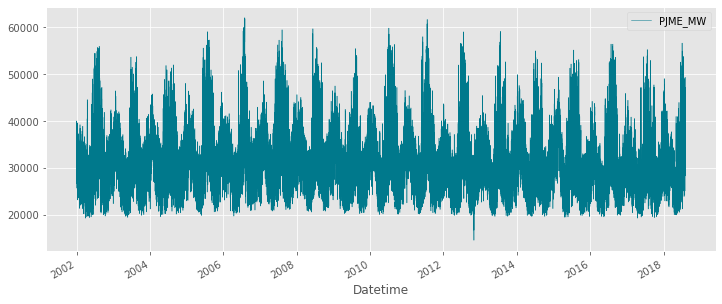

In [16]:
data.plot(figsize = (12, 5), color= colors, linewidth = 0.5)

### Train test split

In [18]:
split_date = '01-Jan-2015'
train = data.loc[data.index <= split_date].copy()
test = data.loc[data.index > split_date].copy()

In [19]:
test.rename(columns={'PJME_MW': 'TEST SET'}).join(train.rename(columns={'PJME_MW': 'TRAINING SET'}), how = 'outer')

,TEST SET,TRAINING SET
Datetime,,
2002-01-01 01:00:00,NaN,30393.0
2002-01-01 02:00:00,NaN,29265.0
2002-01-01 03:00:00,NaN,28357.0
2002-01-01 04:00:00,NaN,27899.0
2002-01-01 05:00:00,NaN,28057.0
...,...,...
2018-08-02 20:00:00,44057.0,NaN
2018-08-02 21:00:00,43256.0,NaN
2018-08-02 22:00:00,41552.0,NaN


<AxesSubplot:title={'center':'PJM Easter'}, xlabel='Datetime'>

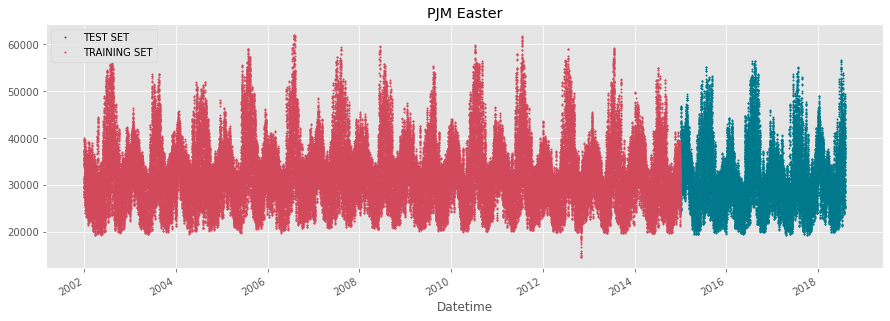

In [22]:
test.rename(columns={'PJME_MW': 'TEST SET'}).join(train.rename(columns={'PJME_MW': 'TRAINING SET'}), how = 'outer').\
plot(figsize=(15, 5), title = 'PJM Easter', style = '.', color = colors, markersize = 2)

### Create Time Series Feature

In [23]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    
    return X

In [24]:
X_train, y_train = create_features(train, label='PJME_MW')
X_test, y_test = create_features(test, label='PJME_MW')

In [25]:
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1


### Create XGBoost Model

In [27]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [28]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

### Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

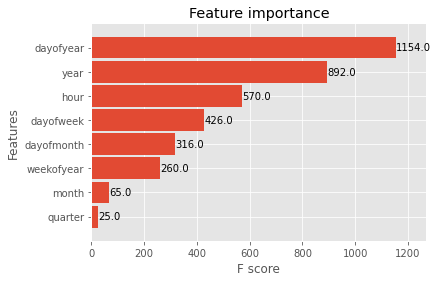

In [29]:
plot_importance(reg, height=0.9)

In [30]:
test['MW_Prediction'] = reg.predict(X_test)
all = pd.concat([test, train], sort=False)

In [31]:
all.head()

,PJME_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MW_Prediction
Datetime,,,,,,,,,,,
2015-12-31 01:00:00,24305.0,2015-12-31 01:00:00,1,3,4,12,2015,365,31,53,26815.033203
2015-12-31 02:00:00,23156.0,2015-12-31 02:00:00,2,3,4,12,2015,365,31,53,26431.603516
2015-12-31 03:00:00,22514.0,2015-12-31 03:00:00,3,3,4,12,2015,365,31,53,26326.818359
2015-12-31 04:00:00,22330.0,2015-12-31 04:00:00,4,3,4,12,2015,365,31,53,26326.818359
2015-12-31 05:00:00,22773.0,2015-12-31 05:00:00,5,3,4,12,2015,365,31,53,26326.818359


<AxesSubplot:xlabel='Datetime'>

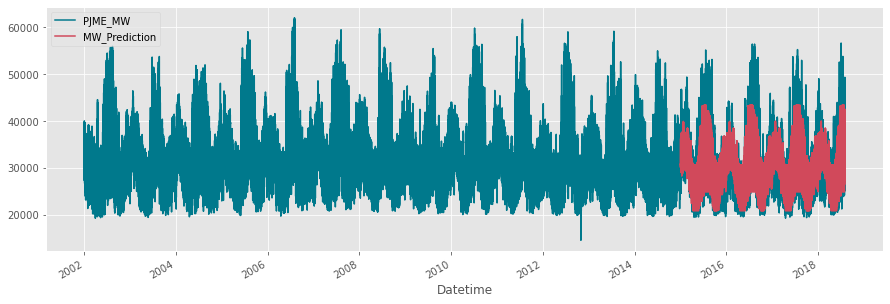

In [32]:
all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5), color = colors)

### 첫달 예측결과만 살펴보기

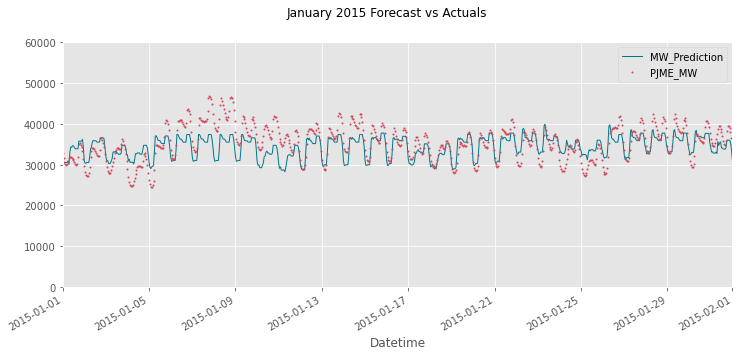

In [37]:
fig, ax = plt.subplots(1)
all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'], color = colors, figsize = (12, 5), markersize= 2, linewidth = 1)
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

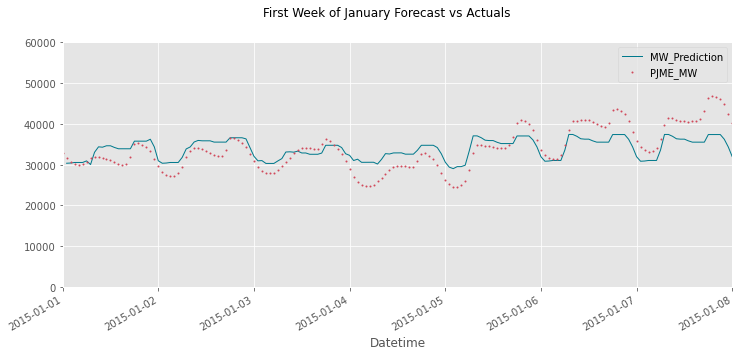

In [38]:
fig, ax = plt.subplots(1)
all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'], color = colors, figsize = (12, 5), markersize= 2, linewidth = 1)
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

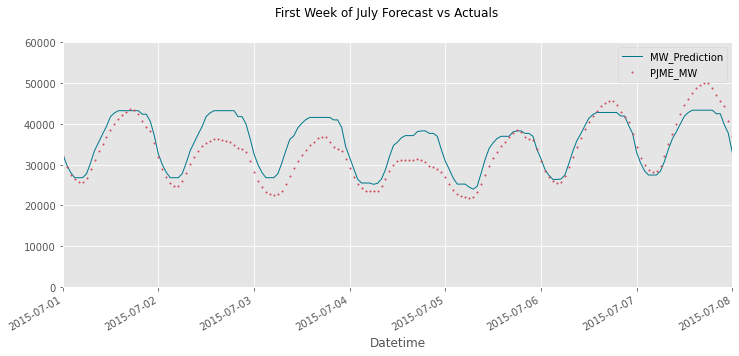

In [39]:
fig, ax = plt.subplots(1)
all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'], color = colors, figsize = (12, 5), markersize= 2, linewidth = 1)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of July Forecast vs Actuals')

### Error metrics

In [40]:
mean_squared_error(y_true=test['PJME_MW'], y_pred=test['MW_Prediction'])

13960913.30565261

In [41]:
mean_absolute_error(y_true=test['PJME_MW'], y_pred=test['MW_Prediction'])

2757.2169004982866

In [42]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [43]:
mean_absolute_percentage_error(y_true=test['PJME_MW'], y_pred=test['MW_Prediction'])

8.510847348494002

### Look at Worst and Best Predicted Days

In [44]:
test['error'] = test['PJME_MW'] - test['MW_Prediction']
test['abs_error'] = test['error'].apply(np.abs)
error_by_day = test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [45]:
test

,PJME_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MW_Prediction,error,abs_error
Datetime,,,,,,,,,,,,,
2015-12-31 01:00:00,24305.0,2015-12-31 01:00:00,1,3,4,12,2015,365,31,53,26815.033203,-2510.033203,2510.033203
2015-12-31 02:00:00,23156.0,2015-12-31 02:00:00,2,3,4,12,2015,365,31,53,26431.603516,-3275.603516,3275.603516
2015-12-31 03:00:00,22514.0,2015-12-31 03:00:00,3,3,4,12,2015,365,31,53,26326.818359,-3812.818359,3812.818359
2015-12-31 04:00:00,22330.0,2015-12-31 04:00:00,4,3,4,12,2015,365,31,53,26326.818359,-3996.818359,3996.818359
2015-12-31 05:00:00,22773.0,2015-12-31 05:00:00,5,3,4,12,2015,365,31,53,26326.818359,-3553.818359,3553.818359
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,2018-01-01 20:00:00,20,0,1,1,2018,1,1,1,34841.941406,9442.058594,9442.058594
2018-01-01 21:00:00,43751.0,2018-01-01 21:00:00,21,0,1,1,2018,1,1,1,34841.941406,8909.058594,8909.058594
2018-01-01 22:00:00,42402.0,2018-01-01 22:00:00,22,0,1,1,2018,1,1,1,35486.136719,6915.863281,6915.863281


In [46]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   36429.839844 -8029.882894  8029.882894
2017 2     24          26445.083333   34425.839844 -7980.756429  7980.756429
           25          24344.458333   31702.664062 -7358.206299  7358.206299
     9     4           26552.416667   33609.351562 -7056.935954  7056.935954
     2     20          27070.583333   33860.238281 -6789.655355  6789.655355
     9     1           27280.500000   33966.476562 -6685.977132  6685.977132
     2     19          24555.500000   31178.527344 -6623.027913  6623.027913
2018 2     21          27572.500000   34057.515625 -6485.015869  6485.015869
2017 3     1           27574.125000   34057.515625 -6483.390869  6483.390869
     2     23          27663.416667   34141.667969 -6478.251872  6478.251872

- #1 worst day - July 4th, 2016 - is a holiday.  
- #3 worst day - December 25, 2015 - Christmas  
- #5 worst day - July 4th, 2016 - is a holiday.  
Looks like our model may benefit from adding a holiday indicator.

In [47]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31390.199219  13795.634766  13795.634766
           14          44427.333333   31185.371094  13241.961751  13241.961751
     9     10          40996.166667   27985.250000  13010.917562  13010.917562
           9           43836.958333   32078.492188  11758.466064  11758.466064
     8     12          45724.708333   34440.406250  11284.303223  11284.303223
2018 1     6           43565.750000   32572.080078  10993.670003  10993.670003
2015 2     20          44694.041667   33874.218750  10819.821045  10819.821045
2017 5     19          38032.583333   27777.609375  10254.974935  10254.974935
2015 2     16          43949.500000   33860.238281  10089.261312  10089.261312
     9     9           42266.875000   32276.361328   9990.514160   9990.514160

In [48]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2018 5     13          24001.500000   24218.675781 -217.174967  338.625000
2016 4     4           28944.125000   28569.861328  374.264323  429.709147
     9     28          27910.833333   28260.042969 -349.209961  479.797038
2015 10    3           25534.875000   25807.496094 -272.620850  485.690348
     9     22          28185.875000   28314.941406 -129.067383  496.139974
     4     20          27369.000000   27608.917969 -239.918376  503.891357
2018 5     17          28035.208333   28513.269531 -478.060872  515.793783
2016 10    2           24659.083333   25016.308594 -357.224284  515.855794
2015 9     21          27988.041667   28057.207031  -69.165365  517.167806
2017 5     13          24752.333333   24626.263672  126.069092  531.713135

### Plotting some best/worst predicted days

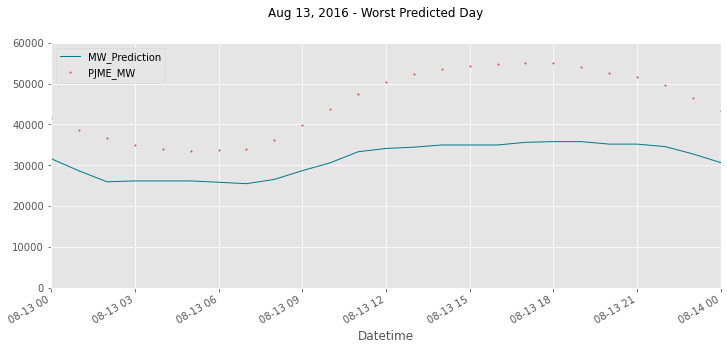

In [49]:
fig, ax = plt.subplots(1)
all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'], color = colors, figsize = (12, 5), markersize= 2, linewidth = 1)
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

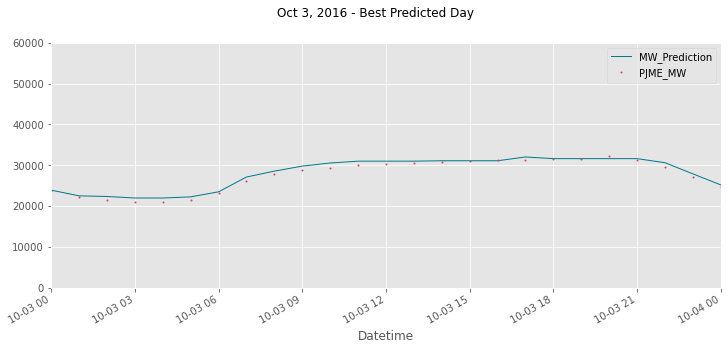

In [50]:
fig, ax = plt.subplots(1)
all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'], color = colors, figsize = (12, 5), markersize= 2, linewidth = 1)
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

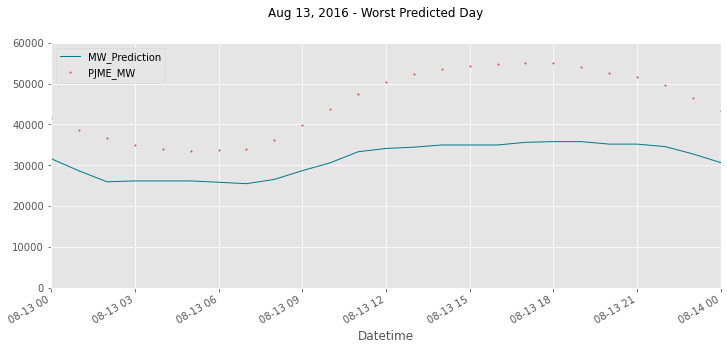

In [51]:
fig, ax = plt.subplots(1)
all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'], color = colors, figsize = (12, 5), markersize= 2, linewidth = 1)
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')